## Sentiment classifier using Vader


In [42]:
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lit
from functools import reduce
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud 
import pandas as pd
import pyspark.sql.functions as F
import re
import string

In [43]:
spark = SparkSession.builder.master('local[*]').config('spark.dirver.maxResultSize', '10g') .config("spark.driver.memory", "20g").appName('AirBnB').getOrCreate()

In [44]:
df = spark.read.csv('preprocessed_reviews.csv', sep=',', escape='"', header=True, inferSchema=True, multiLine=True)

In [45]:
df.show(5)
df.count()

10000

### NLTK Pyspark for reviews classification

## Tokenization

In [46]:
reviews_rdd = partial_df1.select("comments").rdd.flatMap(lambda x: x)
reviews_rdd_lower = reviews_rdd.map(lambda x: x.lower())
reviews_tokenization_rdd = reviews_rdd_lower.map(lambda x: nltk.sent_tokenize(x))
#reviews_tokenization_rdd.collect()
def sentTokenizeWord(x):
    splitted = [word for line in x for word in line.split()]
    return splitted

word_tokenize_rdd = reviews_tokenization_rdd.map(sentTokenizeWord)
word_tokenize_rdd.collect()

[['very',
  'nice',
  'neighborhood,close',
  'enough',
  'to',
  '"a"',
  'train,',
  'comfortable',
  'bed',
  'and',
  'clean',
  'home',
  'over',
  'all.',
  'jennys',
  'cat',
  'is',
  'very',
  'sweet',
  'and',
  'fun',
  'to',
  'play',
  'with,',
  'but',
  'wants',
  'to',
  'sleep',
  'in',
  'bed',
  'with',
  'you',
  'and',
  "won't",
  'shut',
  'up',
  'unless',
  'such',
  'privilages',
  'are',
  'granted',
  '.',
  '.',
  '.',
  'meyow',
  'meyow',
  'meyow.'],
 ["i've",
  'stayed',
  'with',
  'my',
  'friend',
  'at',
  'the',
  'midtown',
  'castle',
  'for',
  'six',
  'days',
  'and',
  'it',
  'was',
  'a',
  'lovely',
  'place',
  'to',
  'be.',
  'a',
  'big',
  'spacious',
  'room',
  'with',
  'a',
  'pointy',
  'roof,',
  'which',
  'really',
  'makes',
  'you',
  'feel',
  'like',
  'staying',
  'in',
  'a',
  'castle.',
  'the',
  'location',
  'is',
  'perfect.',
  'it',
  'is',
  'just',
  'a',
  'few',
  'steps',
  'from',
  "macy's",
  'time',
  's

## Removing stop words, punctuation and spaces

In [47]:
from nltk.corpus import stopwords

def remove_stop(x):
    stop_words = set(stopwords.words('english'))
    filtered_rdd_stopwords = [word for word in x if not word in stop_words]
    return filtered_rdd_stopwords
def remove_punc(x):
    list_punct=list(string.punctuation)
    filtered = [''.join(c for c in s if c not in list_punct) for s in x] 
    filtered_space = [s for s in filtered if s] #remove empty space 
    return filtered
stp_rmv_rdd = word_tokenize_rdd.map(remove_stop)
rmv_punc_rdd = stp_rmv_rdd.map(remove_punc)
rmv_punc_rdd.collect()

[['nice',
  'neighborhoodclose',
  'enough',
  'a',
  'train',
  'comfortable',
  'bed',
  'clean',
  'home',
  'all',
  'jennys',
  'cat',
  'sweet',
  'fun',
  'play',
  'with',
  'wants',
  'sleep',
  'bed',
  'shut',
  'unless',
  'privilages',
  'granted',
  '',
  '',
  '',
  'meyow',
  'meyow',
  'meyow'],
 ['ive',
  'stayed',
  'friend',
  'midtown',
  'castle',
  'six',
  'days',
  'lovely',
  'place',
  'be',
  'big',
  'spacious',
  'room',
  'pointy',
  'roof',
  'really',
  'makes',
  'feel',
  'like',
  'staying',
  'castle',
  'location',
  'perfect',
  'steps',
  'macys',
  'time',
  'square',
  'theatre',
  'district',
  'everything',
  'worked',
  'perfect',
  'keys',
  'etc',
  'thank',
  'much',
  'jennifer',
  'great',
  'time',
  'new',
  'york',
  'attention',
  '4th',
  'floor',
  'without',
  'lift',
  '',
  'definetely',
  'worth',
  'it'],
 ['weve',
  'staying',
  '9',
  'nights',
  'enjoying',
  'center',
  'city',
  'never',
  'sleepsshort',
  'ways',
  'eve

## Lemmatization
Doing things properly with the use of a vocabulary and morphological analysis of words, normally aiming to remove inflectional endings only and to return the base or dictionary form of a word
https://nlp.stanford.edu/IR-book/html/htmledition/stemming-and-lemmatization-1.html

In [48]:
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()
lem_words_rdd = rmv_punc_rdd.map(lambda x: [lemmatizer.lemmatize(s) for s in x])
joined_tokens_rdd = lem_words_rdd.map(lambda x: ' '.join(x))
joined_tokens_rdd.collect()

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/salihamehboob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


['nice neighborhoodclose enough a train comfortable bed clean home all jenny cat sweet fun play with want sleep bed shut unless privilages granted    meyow meyow meyow',
 'ive stayed friend midtown castle six day lovely place be big spacious room pointy roof really make feel like staying castle location perfect step macys time square theatre district everything worked perfect key etc thank much jennifer great time new york attention 4th floor without lift  definetely worth it',
 'weve staying 9 night enjoying center city never sleepsshort way everywhere manhattan subway walk midtown castle beauftiful tastful place jennifer torus relaxed friendly host  thats  three berliner  recommand place good wifi little kitchen too',
 'wonderful stay jennifers charming apartment organized helpful would definitely recommend staying midtown castle',
 'hi everyone would say greatest compliment jennifer host midtown castle spent lovely apartment heart manhattan one month april 2012 remember time best ap

### Creating Phrases
Chunking: shallow parsing, goruping words into chunks
Chinking: remove chunks from words
POS: a tagger assings part of speech to each word.
https://www.nltk.org/book/ch07.html

In [49]:
nltk.download('averaged_perceptron_tagger')
def extractPhraseFunct(x):
    stop_words=set(stopwords.words('english'))
    def leaves(tree):
        """Finds NP (nounphrase) leaf nodes of a chunk tree."""
        for subtree in tree.subtrees(filter = lambda t: t.label()=='NP'):
            yield subtree.leaves()
    
    def get_terms(tree):
        for leaf in leaves(tree):
            term = [w for w,t in leaf if not w in stop_words]
            yield term
    sentence_re = r'(?:(?:[A-Z])(?:.[A-Z])+.?)|(?:\w+(?:-\w+)*)|(?:\$?\d+(?:.\d+)?%?)|(?:...|)(?:[][.,;"\'?():-_`])'
    grammar = r"""
    NBAR:
    {<NN.*|JJ>*<NN.*>}  # Nouns and Adjectives, terminated with Nouns
        
    NP:
    {<NBAR>}
    {<NBAR><IN><NBAR>}  # Above, connected with in/of/etc...
    """
    chunker = nltk.RegexpParser(grammar)
    tokens = nltk.regexp_tokenize(x,sentence_re)
    postoks = nltk.tag.pos_tag(tokens) #Part of speech tagging 
    tree = chunker.parse(postoks) #chunking
    terms = get_terms(tree)
    temp_phrases = []
    for term in terms:
        if len(term):
            temp_phrases.append(' '.join(term))
    
    finalPhrase = [w for w in temp_phrases if w] #remove empty lists
    return finalPhrase
    

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/salihamehboob/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [50]:
extract_phrase_rdd = joined_tokens_rdd.map(extractPhraseFunct)
extract_phrase_rdd.collect()

[['train comfortable bed clean home',
  'jenny cat sweet fun play',
  'want sleep',
  'privilages',
  'meyow meyow meyow'],
 ['friend midtown',
  'day lovely place',
  'big spacious room pointy roof',
  'feel',
  'castle location perfect step macys time square theatre district everything',
  'thank much jennifer great time new york attention',
  'floor',
  'lift'],
 ['weve',
  'night',
  'center city',
  'sleepsshort way',
  'manhattan subway',
  'midtown castle beauftiful tastful place jennifer torus',
  'friendly host thats',
  'berliner recommand place good wifi little kitchen'],
 ['wonderful stay jennifers', 'apartment', 'helpful', 'midtown castle'],
 ['hi everyone',
  'compliment jennifer host midtown castle spent',
  'apartment heart',
  'month april',
  'remember time',
  'apartment',
  'ave right',
  'corner everything',
  'stay jennifer',
  'vigorous responsible host thanks',
  'apartment everyone',
  'quiet place',
  'center',
  'midtown'],
 ['jennifer',
  'helpful place',
  

In [51]:
joined_phrase_rdd = extract_phrase_rdd.map(lambda x: ' '.join(x))
joined_phrase_rdd.collect()

['train comfortable bed clean home jenny cat sweet fun play want sleep privilages meyow meyow meyow',
 'friend midtown day lovely place big spacious room pointy roof feel castle location perfect step macys time square theatre district everything thank much jennifer great time new york attention floor lift',
 'weve night center city sleepsshort way manhattan subway midtown castle beauftiful tastful place jennifer torus friendly host thats berliner recommand place good wifi little kitchen',
 'wonderful stay jennifers apartment helpful midtown castle',
 'hi everyone compliment jennifer host midtown castle spent apartment heart month april remember time apartment ave right corner everything stay jennifer vigorous responsible host thanks apartment everyone quiet place center midtown',
 'jennifer helpful place location convenient pleasure midtown castle recommend thanks',
 'apartment real castle old unique age stain bathroom floor dark discoloration carpet building long time happy way apartm

## Using nltk Vader for sentiments
Vader returns the score of how positive and negative a review can be. Scores are used to generate ratings by normalizing and scaling them in the integer range of [1-5]. v = score-min/(max-min). Analyzer returns score from -1 to 1. This is known as fine grained sentiment analysis.

In [65]:
import numpy as np
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
def sentimentWordsFunct(x):
    analyzer = SentimentIntensityAnalyzer() 
    senti_list_temp = []
    vs = analyzer.polarity_scores(x)
    senti_list_temp.append((x,vs))
    sentiment_list  = []
    for j in senti_list_temp:
        first = j[0]
        second = j[1]
        for (k,v) in second.items():
            if k == 'compound':
                norm_score = (v+1)/2
                if v < 0.0:
                    sentiment_list.append((first, "Negative",v,round(5*norm_score)))
                elif v == 0.0:
                    sentiment_list.append((first, "Neutral",v,round(5*norm_score)))
                else:
                    sentiment_list.append((first, "Positive",v,round(5*norm_score)))
    return sentiment_list
sentiment_rdd = joined_phrase_rdd.map(sentimentWordsFunct)
sentiment_rdd.collect()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/salihamehboob/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


[[('train comfortable bed clean home jenny cat sweet fun play want sleep privilages meyow meyow meyow',
   'Positive',
   0.9325,
   5)],
 [('friend midtown day lovely place big spacious room pointy roof feel castle location perfect step macys time square theatre district everything thank much jennifer great time new york attention floor lift',
   'Positive',
   0.9538,
   5)],
 [('weve night center city sleepsshort way manhattan subway midtown castle beauftiful tastful place jennifer torus friendly host thats berliner recommand place good wifi little kitchen',
   'Positive',
   0.7269,
   4)],
 [('wonderful stay jennifers apartment helpful midtown castle',
   'Positive',
   0.7579,
   4)],
 [('hi everyone compliment jennifer host midtown castle spent apartment heart month april remember time apartment ave right corner everything stay jennifer vigorous responsible host thanks apartment everyone quiet place center midtown',
   'Positive',
   0.8074,
   5)],
 [('jennifer helpful place lo

## converting rdd to pyspark dataframe

In [66]:
sentiments = sentiment_rdd.toDF()
sentiments = sentiments.select(F.col("_1._1").alias("clean_comment"), F.col("_1._2").alias("sentiment"),
                               F.col("_1._3").alias("score"),F.col("_1._4").alias("rating"))
sentiments.printSchema()
sentiments.show()

root
 |-- clean_comment: string (nullable = true)
 |-- sentiment: string (nullable = true)
 |-- score: double (nullable = true)
 |-- rating: long (nullable = true)

+--------------------+---------+------+------+
|       clean_comment|sentiment| score|rating|
+--------------------+---------+------+------+
|train comfortable...| Positive|0.9325|     5|
|friend midtown da...| Positive|0.9538|     5|
|weve night center...| Positive|0.7269|     4|
|wonderful stay je...| Positive|0.7579|     4|
|hi everyone compl...| Positive|0.8074|     5|
|jennifer helpful ...| Positive|0.8979|     5|
|apartment real ca...| Positive|0.9578|     5|
|jennifers great m...| Positive|0.8934|     5|
|jennifer nice hos...| Positive|0.8176|     5|
|cute studio wonde...| Positive|0.9712|     5|
|great location co...| Positive|0.8807|     5|
|jennifers distanc...| Positive|0.7845|     4|
|jennifer good com...| Positive|0.9601|     5|
|space gem heart m...| Positive|0.9451|     5|
|airbnb experience...| Positive|0.62

In [ ]:
#sentiments_pd['new_col'] = range(1, len(sentiments_pd) + 1)
#df['new_col'] = range(1, len(df) + 1)
#df_final = pd.merge(df, sentiments_pd, on='new_col',how='left')
#df_final.head(10)

In [ ]:
#df_final=df_right.drop(columns=['new_col','reviews','Unnamed: 0'])
#df_final('Clean_reviews_sentiments.csv')

In [68]:
df_source = df.withColumn("id", F.monotonically_increasing_id())
df_source.show(4)

+----------+-------------------+-----------+--------------------+---+
|listing_id|               date|reviewer_id|            comments| id|
+----------+-------------------+-----------+--------------------+---+
|      2060|2008-09-22 00:00:00|       2865|very nice neighbo...|  0|
|      2595|2009-12-10 00:00:00|      38960|I've stayed with ...|  1|
|      2595|2010-04-09 00:00:00|      71130|We've been stayin...|  2|
|      2595|2010-05-25 00:00:00|     117113|We had a wonderfu...|  3|
+----------+-------------------+-----------+--------------------+---+
only showing top 4 rows



In [69]:
df_target= sentiments.withColumn("id", F.monotonically_increasing_id())
df_target.show(5)

+--------------------+---------+------+------+---+
|       clean_comment|sentiment| score|rating| id|
+--------------------+---------+------+------+---+
|train comfortable...| Positive|0.9325|     5|  0|
|friend midtown da...| Positive|0.9538|     5|  1|
|weve night center...| Positive|0.7269|     4|  2|
|wonderful stay je...| Positive|0.7579|     4|  3|
|hi everyone compl...| Positive|0.8074|     5|  4|
+--------------------+---------+------+------+---+
only showing top 5 rows



In [70]:
df_results = df_source.join(df_target, "id", "inner").drop("id","_c0")
df_results.show(5)

+----------+-------------------+-----------+--------------------+--------------------+---------+------+------+
|listing_id|               date|reviewer_id|            comments|       clean_comment|sentiment| score|rating|
+----------+-------------------+-----------+--------------------+--------------------+---------+------+------+
|      2060|2008-09-22 00:00:00|       2865|very nice neighbo...|train comfortable...| Positive|0.9325|     5|
|      2595|2009-12-10 00:00:00|      38960|I've stayed with ...|friend midtown da...| Positive|0.9538|     5|
|      2595|2010-04-09 00:00:00|      71130|We've been stayin...|weve night center...| Positive|0.7269|     4|
|      2595|2010-05-25 00:00:00|     117113|We had a wonderfu...|wonderful stay je...| Positive|0.7579|     4|
|      2595|2012-05-07 00:00:00|    1783688|Hi to everyone!
...|hi everyone compl...| Positive|0.8074|     5|
+----------+-------------------+-----------+--------------------+--------------------+---------+------+------+
on

In [71]:
df_sentiment_results = df_results.toPandas()
df_sentiment_results.to_csv("reviews_ratings.csv")
df_sentiment_results.head()

,listing_id,date,reviewer_id,comments,clean_comment,sentiment,score,rating
0,2060,2008-09-22,2865,"very nice neighborhood,close enough to ""A"" tra...",train comfortable bed clean home jenny cat swe...,Positive,0.9325,5
1,2595,2009-12-10,38960,I've stayed with my friend at the Midtown Cast...,friend midtown day lovely place big spacious r...,Positive,0.9538,5
2,2595,2010-04-09,71130,"We've been staying here for about 9 nights, en...",weve night center city sleepsshort way manhatt...,Positive,0.7269,4
3,2595,2010-05-25,117113,We had a wonderful stay at Jennifer's charming...,wonderful stay jennifers apartment helpful mid...,Positive,0.7579,4
4,2595,2012-05-07,1783688,Hi to everyone!\r\nWould say our greatest comp...,hi everyone compliment jennifer host midtown c...,Positive,0.8074,5


## Analysis based on extracted phrases

In [72]:
#freqDistRDD = extract_phrase_rdd.flatMap(lambda x : nltk.FreqDist(x).most_common()).map(lambda x: x).reduceByKey(lambda x,y : x+y).sortBy(lambda x: x[1], ascending = False)


In [73]:
#freqDistRDD.take(50)

[('apartment', 11873),
 ('place', 11471),
 ('stay', 11338),
 ('host', 8460),
 ('everything', 7877),
 ('day', 6938),
 ('home', 6012),
 ('room', 4497),
 ('location', 4153),
 ('people', 4140),
 ('night', 4126),
 ('minute', 4048),
 ('city', 3573),
 ('new york', 3513),
 ('block', 3355),
 ('thanks', 3284),
 ('time', 3284),
 ('question', 3184),
 ('great host', 3133),
 ('area', 2934),
 ('great location', 2853),
 ('reservation', 2693),
 ('distance', 2611),
 ('anyone', 2587),
 ('family', 2524),
 ('day arrival', 2486),
 ('minute walk', 2376),
 ('space', 2179),
 ('feel', 2146),
 ('way', 2141),
 ('house', 2125),
 ('street', 2041),
 ('min', 2008),
 ('friend', 1972),
 ('great place', 1952),
 ('subway station', 1942),
 ('neighborhood', 1819),
 ('picture', 1802),
 ('week', 1792),
 ('great stay', 1760),
 ('experience', 1666),
 ('thing', 1595),
 ('great time', 1560),
 ('anything', 1539),
 ('subway', 1424),
 ('person', 1408),
 ('u feel', 1377),
 ('recommend place', 1371),
 ('manhattan', 1366),
 ('brooklyn

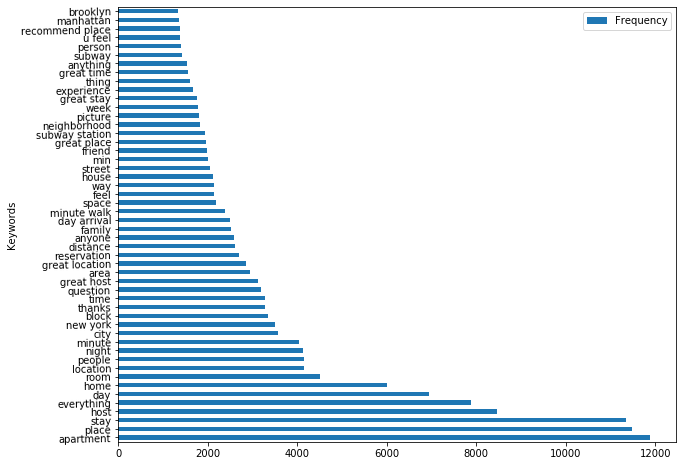

In [74]:
#df_fDist = freqDistRDD.toDF() #converting RDD to spark dataframe
#df_fDist.createOrReplaceTempView("keywordTable") 
#df2 = spark.sql("SELECT _1 AS Keywords, _2 as Frequency from keywordTable limit 50") #renaming columns 
#pandD = df2.toPandas() #converting spark dataframes to pandas dataframes
#pandD.plot.barh(x='Keywords', y='Frequency', rot=1, figsize=(10,8))

## Word Cloud

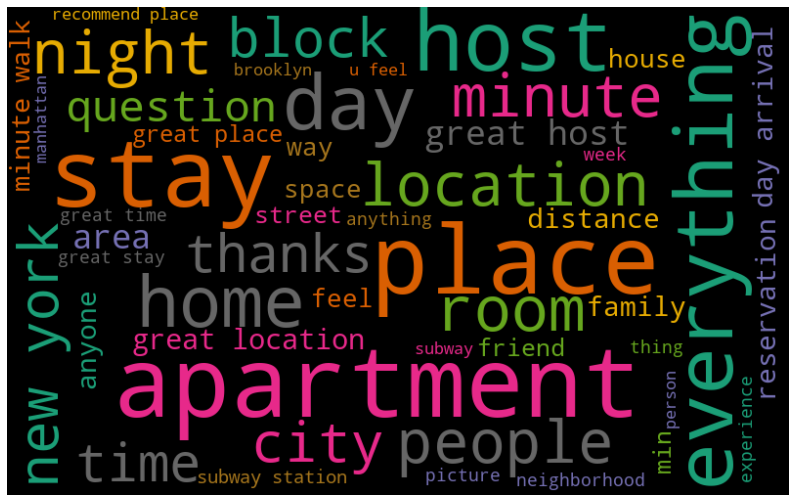

In [75]:
#wordcloudConvertDF = pandD.set_index('Keywords').T.to_dict('records')
#wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate_from_frequencies(dict(*wordcloudConvertDF))
#plt.figure(figsize=(14, 10))    
#plt.imshow(wordcloud, interpolation="bilinear")
#plt.axis('off')
#plt.show()